# Assignment 1

In [52]:
from scipy import io
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import tikzplotlib
import seaborn
from scipy.io.wavfile import write
%matplotlib notebook
np.random.seed(1)

In [2]:
# load dataset
filepath = os.path.abspath('./../../../data/ass_01/amp_data.mat')
assert os.path.exists(filepath), 'Please download the dataset. I cannot find it at: %s' %(filepath)
file = io.loadmat(filepath)
amp_data = file['amp_data']

# Question 1

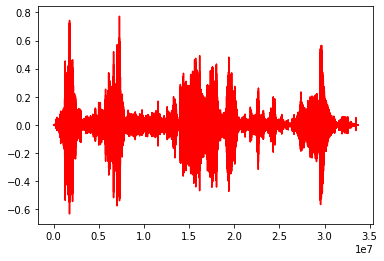

In [3]:
# plot data along t axis
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_01.png")
# save_filename_tex = os.path.abspath("./presentation/presentation_figures/fig_01.tex")

plt.figure()
plt.plot(amp_data[:, 0], 'r')
plt.savefig(save_filename_png)
plt.show()
# tikzplotlib.save(save_filename_tex)

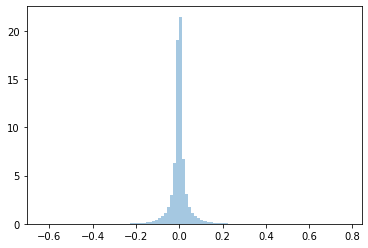

In [4]:
# plot histogram
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_02.png")
plt.figure()
seaborn.distplot(amp_data[:, 0], bins=100, kde=False, norm_hist=True)
plt.savefig(save_filename_png)
plt.show()

In [5]:
# non overlapping splitting
D = 21
remaining_samples = amp_data.shape[0] % D
X = amp_data[:-remaining_samples] if remaining_samples > 0 else amp_data
X = X.reshape((int(X.shape[0]/D), D))
X_initial = copy.deepcopy(X)

In [6]:
# prepare dataset
np.random.shuffle(X)
index_tr = np.int(np.floor(X.shape[0] * 0.7))
index_val = np.int(np.floor(X.shape[0] * 0.15))
index_test = np.int(np.floor(X.shape[0] * 0.15))

train_start = 0
train_stop = index_tr + 1
val_start = index_tr + 1
val_stop = index_tr+1+index_val
test_start = index_tr+1+index_val
test_stop = index_tr+1+2*index_val


def split_x(X, start, stop):
    return X[start:stop, :20]


def split_y(X, start, stop):
    return X[start:stop, 20]


X_shuf_train = split_x(X, train_start, train_stop)
y_shuf_train = split_y(X, train_start, train_stop)

X_shuf_val = split_x(X, val_start, val_stop)
y_shuf_val = split_y(X, val_start, val_stop)

X_shuf_test = split_x(X, test_start, test_stop)
y_shuf_test = split_y(X, test_start, test_stop)

# Question 2

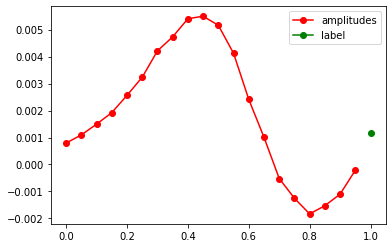

In [7]:
# plot single row 
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_03.png")
i = 1000 # nof row

plt.figure()
plt.plot(np.linspace(0, 19/20, 20), X_shuf_train[i], 'r-o', label="amplitudes");
plt.plot(1, y_shuf_train[i], 'g-o', label = "label");
plt.legend();
plt.savefig(save_filename_png)
plt.show(block=False);

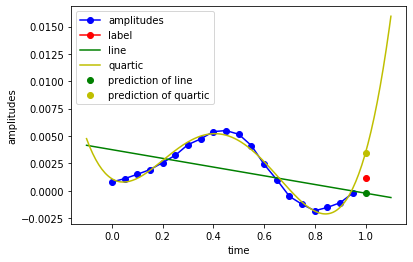

In [8]:
class model:
    def __init__(self, phi):
        self.phi = phi
        self.w = None
        
    def fit(self, t: np.array, labels: np.array):
        '''
        t: NxD
        labels: Nx1
        
        w : Dx1
        '''
        w, residuals, rank, sv = np.linalg.lstsq(self.phi(t), labels, rcond=None)
        self.w = w
        return w
    
    def predict(self, t: np.array):
        '''
        t : NxD
        w : Dx1
        
        Nx1
        '''
        return np.matmul(self.phi(t), self.w)
    
    
    def mse(self, X, Y):
        '''
        t : NxD
        w : Dx1
        
        Nx1
        '''
        assert len(X.shape) == 2
        assert len(Y.shape) == 2
        assert Y.shape[1] == 1
        assert X.shape[0] == Y.shape[0]
        
        Y_pred = self.predict(X)
        assert Y_pred.shape == Y.shape
        return np.mean(np.square(Y - Y_pred))
    
    def mae(self, X, Y):
        '''
        t : NxD
        w : Dx1
        
        Nx1
        '''
        assert len(X.shape) == 2
        assert len(Y.shape) == 2
        assert Y.shape[1] == 1
        assert X.shape[0] == Y.shape[0]
        
        Y_pred = self.predict(X)
        assert Y_pred.shape == Y.shape
        return np.mean(np.abs(Y - Y_pred))

def affine_phi(t):
    t = np.expand_dims(t, -1)
    t = np.concatenate((np.ones_like(t), t), axis=1)
    return t

def quartic_phi(t):
    t = np.expand_dims(t, -1)
    t = np.concatenate((np.ones_like(t), t, t**2, t**3, t**4), axis=1)
    return t

linear_model = model(phi=affine_phi)
quartic_model = model(phi=quartic_phi)


x = np.linspace(0, 19 / 20, 20)
y = X_shuf_train[i]

linear_model.fit(x, y)
quartic_model.fit(x, y)

t = np.linspace(0, 19 / 20, 20)
t_ext = np.linspace(-0.1, 1.1, 200)

# subquestion a
plt.figure()
# real points
plt.plot(x, y, 'b-o', label = 'amplitudes')
# real label
plt.plot(np.array([1]), y_shuf_train[i], 'r-o', label = 'label')

# fit line
plt.plot(t_ext, linear_model.predict(t_ext), 'g-', label = 'line')
# fit quartic
plt.plot(t_ext, quartic_model.predict(t_ext), 'y-', label = 'quartic')

# prediction on 20/20 from line
plt.plot(np.array([1]), linear_model.predict(np.array([1])), 'go', label = 'prediction of line')
# prediction on 20/20 from quartic
plt.plot(np.array([1]), quartic_model.predict(np.array([1])), 'yo', label = 'prediction of quartic')

plt.xlabel("time")
plt.ylabel("amplitudes")
plt.legend();
plt.savefig(save_filename_png)
plt.show(block=False)

# Question 3

In [9]:
C = 20
K = 3
def Phi(C, K):
    t = np.linspace(0, (C-1)/C, C)
    return np.stack([t**k for k in range(K)], axis=1)

In [10]:
x_tmp = np.expand_dims(X_shuf_train[i], -1)

def phi_t(t):
    return np.stack([t**k for k in range(K)], axis=1).T

def make_vv(C, K, x_tmp):
    x_tmp = np.expand_dims(x_tmp, -1)
    F = Phi(C,K)
    F_T = np.transpose(F)
    
    return ((((F_T.dot(F))**-1).dot(F_T.dot(x_tmp)).T).dot(phi_t(np.array([1]))).dot(x_tmp.T).T / ((x_tmp.T).dot(x_tmp))).T

In [11]:
# demonstration
C = 20
K = 5
v = make_vv(C, K, X_shuf_train[i])

print(quartic_model.predict(np.array([1])))

print(v.dot(np.expand_dims(X_shuf_train[i], -1)))


[0.00347088]
[[0.04403048]]


# Question 4

In [20]:
def new_affine_phi(X):
    assert len(X.shape) == 2, "Shape of all thing must have length 2"
    raw_ones_column = np.expand_dims(np.ones(X.shape[0]), -1)
    return np.concatenate((X, raw_ones_column), axis=1)

affine_model = model(new_affine_phi)
affine_model.fit(X_shuf_train, np.expand_dims(y_shuf_train, -1))

# print(affine_model.mse(X_shuf_train, np.expand_dims(y_shuf_train, -1)))
# print(affine_model.mse(X_shuf_val, np.expand_dims(y_shuf_val, -1)))

2.196576090246768e-33
3.189879658814443e-05


In [29]:
C = np.arange(19,-1, -1)

In [30]:
print(C)

[19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


In [31]:
X_shuf_train[:,C[-1]:].shape

(1123776, 20)

In [37]:
affine_model1 = model(new_affine_phi)
affine_model1.fit(X_shuf_train[:,C[0]:], np.expand_dims(y_shuf_train, -1))
affine_model1.mse(X_shuf_train[:,C[0]:], np.expand_dims(y_shuf_train, -1))

3.664508840001156e-05

In [60]:
mse_tr = []
mse_val = []
mse_te = []
affine_model = []
for i, c in enumerate(C):
    affine_model.append(model(new_affine_phi))
    affine_model[i].fit(X_shuf_train[:,c:], np.expand_dims(y_shuf_train, -1))
    train_err = affine_model[i].mse(X_shuf_train[:,c:], np.expand_dims(y_shuf_train, -1))
    valid_err = affine_model[i].mse(X_shuf_val[:,c:], np.expand_dims(y_shuf_val, -1))
    test_err = affine_model[i].mse(X_shuf_test[:,c:], np.expand_dims(y_shuf_test, -1))
    print("\nModel with %d weigths + bias:" %(20-c))
    print("training err: ", train_err)
    print("valid err   : ", valid_err)
    print("test err    : ", test_err)
    print("\n")
    mse_tr.append(train_err)
    mse_val.append(valid_err)
    mse_te.append(test_err)


Model with 1 weigths + bias:
training err:  3.664508840001156e-05
valid err   :  3.733382354873095e-05
test err    :  3.65540608101305e-05



Model with 2 weigths + bias:
training err:  1.1529938042827189e-05
valid err   :  1.197863512060466e-05
test err    :  1.1715203535997258e-05



Model with 3 weigths + bias:
training err:  9.831919932351154e-06
valid err   :  9.936445354158727e-06
test err    :  1.0063725108705976e-05



Model with 4 weigths + bias:
training err:  9.454929311323047e-06
valid err   :  9.60554440328015e-06
test err    :  9.729734922850078e-06



Model with 5 weigths + bias:
training err:  8.991689871730614e-06
valid err   :  9.24181992735788e-06
test err    :  9.272003873054174e-06



Model with 6 weigths + bias:
training err:  8.804902029098194e-06
valid err   :  8.972311171016778e-06
test err    :  9.093060925757528e-06



Model with 7 weigths + bias:
training err:  8.309451616570976e-06
valid err   :  8.302582465922646e-06
test err    :  8.582776786807088e-06



<IPython.core.display.Javascript object>


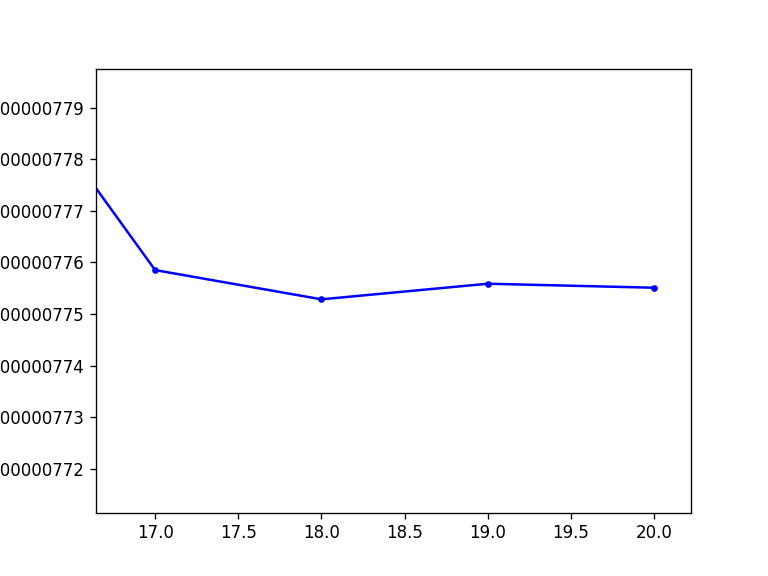

In [54]:
plt.figure()
plt.plot(20-C, mse_tr, 'r.-')
plt.plot(20-C, mse_val, 'b.-')
plt.plot(20-C, mse_te, 'g.-')
plt.show()

best model is 17


<IPython.core.display.Javascript object>


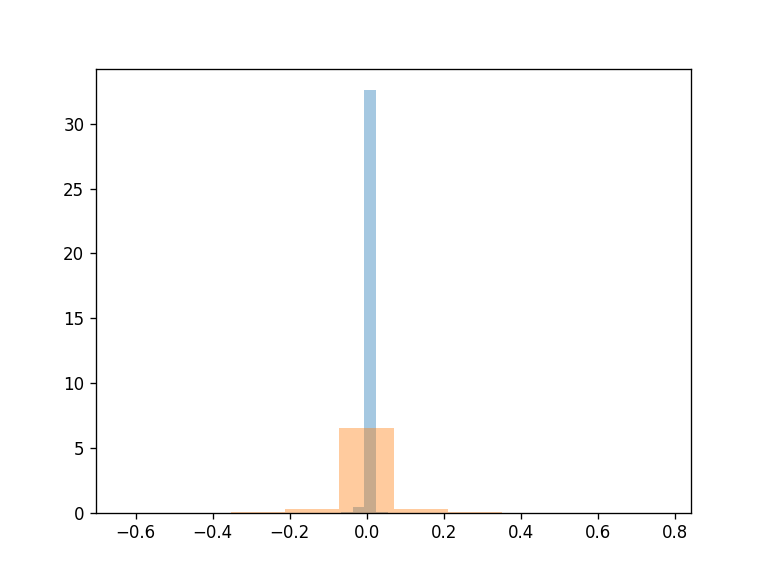

In [70]:
c_arg = np.argmin(np.array(mse_val))
print("best model is %d" %c_arg)

plt.figure()
res = affine_model[c_arg].predict(X_shuf_val[:,C[c_arg]:]) - np.expand_dims(y_shuf_val, -1)
seaborn.distplot(res, bins = 10, kde=False, norm_hist=True)
seaborn.distplot(amp_data[:, 0], bins=10, kde=False, norm_hist=True)
plt.show()

In [ ]:
affine_model